In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls /content/drive/MyDrive/DESProject
!ls /content/drive/MyDrive/DESProject/spark-3.5.2-bin-hadoop3.tgz
!tar xf /content/drive/MyDrive/DESProject/spark-3.5.2-bin-hadoop3.tgz
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install -q findspark
!pip install -q pyspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.2-bin-hadoop3"

books_data.csv	  data_engg_books_data_from_valid_categories.csv       spark-3.5.2-bin-hadoop3.tgz
Books_rating.csv  data_engg_books_rating_from_valid_categories_df.csv  Untitled0.ipynb
/content/drive/MyDrive/DESProject/spark-3.5.2-bin-hadoop3.tgz


In [3]:
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
input_type = 'sample'
spark = SparkSession.builder\
         .master("local")\
         .appName("Amazon_book_reviews_project")\
         .config('spark.ui.port', '4050')\
         .getOrCreate()

In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, isnan, lit, size, collect_list, explode
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

In [ ]:
book_data  = spark.read.csv('C:\Users\HAN4COB\.conda\envs\test\Data_Science_in_practice\data_engg_books_data_from_valid_categories.csv', sep="\t", header=True, inferSchema=True)
book_ratings = spark.read.csv('C:\Users\HAN4COB\.conda\envs\test\Data_Science_in_practice\data_engg_books_rating_from_valid_categories_df.csv', sep = '\t', header=True, inferSchema=True)

In [4]:
#book_data  = spark.read.csv('/content/drive/MyDrive/DESProject/data_engg_books_data_from_valid_categories.csv', sep="\t", header=True, inferSchema=True)
#book_ratings = spark.read.csv('/content/drive/MyDrive/DESProject/data_engg_books_rating_from_valid_categories_df.csv', sep = '\t', header=True, inferSchema=True)

In [5]:
# Display initial rows
book_data.show(10)
book_ratings.show(10)


+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+--------------------+------------+--------------------+
|         description|             authors|               image|         previewLink|           publisher|publishedDate|            infoLink|          categories|ratingsCount|               Title|
+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+--------------------+------------+--------------------+
|                NULL|    ['Julie Strain']|http://books.goog...|http://books.goog...|                NULL|         1996|http://books.goog...|Comics & Graphic ...|         0.0|Its Only Art If I...|
|This resource inc...|    ['David R. Ray']|http://books.goog...|http://books.goog...|                NULL|         2000|http://books.goog...|            Religion|         0.0|Wonderful Worship...|
|Julia Thomas f

In [6]:
# Count the number of rows in each dataset
print("Books Data Count:", book_data.count())
print("Books Rating Data Count:", book_ratings.count())

Books Data Count: 131666
Books Rating Data Count: 1972815


In [13]:
# Handle missing values
book_data = book_data.dropna(subset=["Title"])
#book_data = book_data.withColumn("categories", col("categories").na.fill("Unknown_category"))
book_data = book_data.withColumn(
    "categories",
    when(col("categories").isNull(), "Unknown_category").otherwise(col("categories"))
)
#book_data = book_data.withColumn("ratingsCount", col("ratingsCount").na.fill(0))
book_data = book_data.withColumn(
    "ratingsCount",
    when(col("ratingsCount").isNull(), 0).otherwise(col("ratingsCount"))
)


In [14]:
# Drop unnecessary columns from book_data
columns_to_drop_book_data = ['description', 'authors', 'image', 'previewLink', 'publisher', 'publishedDate', 'infoLink']
book_data = book_data.drop(*columns_to_drop_book_data)

# Drop unnecessary columns from book_ratings
columns_to_drop_book_ratings = ['Id', 'User_id', 'profileName']
book_ratings = book_ratings.drop(*columns_to_drop_book_ratings)

# Remove duplicate rows based on 'Title'
book_data = book_data.dropDuplicates(["Title"])

# Merge book_data and book_ratings on 'Title'
book_df = book_data.join(book_ratings, on="Title", how="inner")

# Exclude 'Fiction' category
filtered_data_no_fiction = book_df.filter(col("categories") != "Fiction")


In [15]:
# Identify the top 10 categories excluding 'Fiction'
top_categories_no_fiction = (
    filtered_data_no_fiction.groupBy("categories")
    .count()
    .orderBy(col("count").desc())
    .limit(10)
    .select("categories")
)

# Filter data for the top 10 categories
filtered_data_final = filtered_data_no_fiction.join(top_categories_no_fiction, on="categories", how="inner")

# Bin 'review/score' into intervals
bins = [0, 1, 2, 3, 4, 5]
labels = ['0-1', '1-2', '2-3', '3-4', '4-5']

In [16]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def bin_score(score):
    for i in range(len(bins) - 1):
        if bins[i] <= score < bins[i + 1]:
            return labels[i]
    return None

bin_score_udf = udf(bin_score, StringType())
filtered_data_final = filtered_data_final.withColumn("score_bins", bin_score_udf(col("review/score")))

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
# Group data by categories and score bins
score_distribution = (
    filtered_data_final.groupBy("categories", "score_bins")
    .count()
    .orderBy("categories", "score_bins")
)

# Collect data to visualize using Matplotlib
data_for_plot = score_distribution.collect()


# # Define a window partitioned by 'categories'
window_spec = Window.partitionBy("categories")

# # Calculate the normalized count within each category
# score_distribution = score_distribution.withColumn(
#     "normalized_count",
#     col("count") / sum("count").over(window_spec)
# )
score_distribution = score_distribution.withColumn(
    "normalized_count", col("count")
)

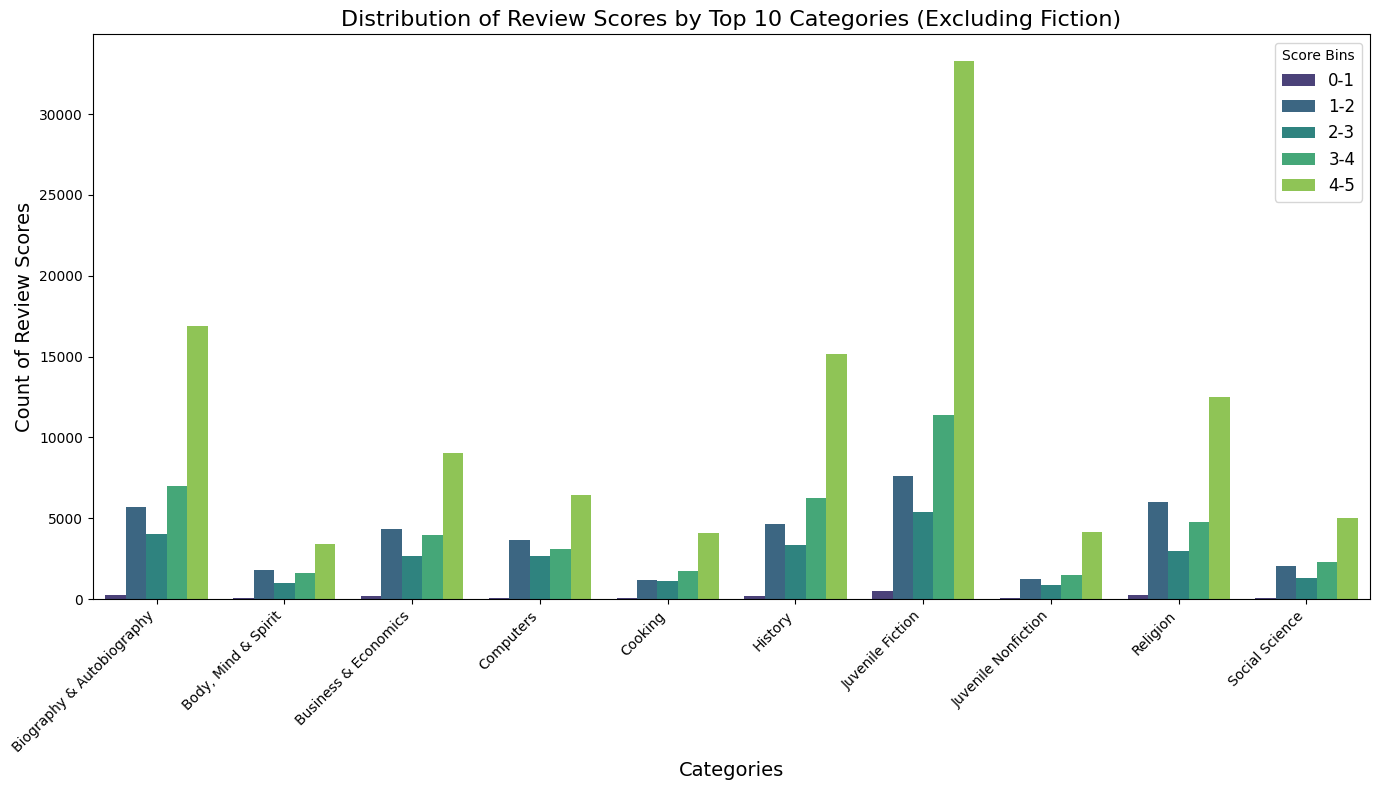

In [21]:
# Prepare data for plotting
categories = []
score_bins = []
counts = []

for row in data_for_plot:
    categories.append(row["categories"])
    score_bins.append(row["score_bins"])
    counts.append(row["count"])

# Create a visualization using Matplotlib
plt.figure(figsize=(14, 8))
sns.barplot(
    x=categories,
    y=counts,
    hue=score_bins,
    palette="viridis"
)

# Customize the plot
plt.title("Distribution of Review Scores by Top 10 Categories (Excluding Fiction)", fontsize=16)
plt.xlabel("Categories", fontsize=14)
plt.ylabel("Count of Review Scores", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Score Bins", fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


In [22]:
# Define the total sample size
sample_size = 40000

# Calculate the total row count of the dataset
total_count = book_df.count()

# Calculate the sampling fraction for each group
grouped_counts = (
    book_df.groupBy("categories", "review/score")
    .agg(count("*").alias("group_count"))
)

# Add a fraction column based on the desired sample size
grouped_counts = grouped_counts.withColumn(
    "sampling_fraction",
    (col("group_count") / total_count) * sample_size / col("group_count")
)

# Join the fractions back to the original DataFrame
book_df_with_fractions = book_df.join(
    grouped_counts.select("categories", "review/score", "sampling_fraction"),
    on=["categories", "review/score"],
    how="inner",
)

# Perform sampling using the calculated fractions
sampled_data = book_df_with_fractions.sampleBy(
    col("categories"), fractions=dict(grouped_counts.select("categories", "sampling_fraction").collect()), seed=42
)

# Save the sampled data to CSV
sampled_data.write.csv(
    r"C:\Users\HAN4COB\.conda\envs\test\Data_Science_in_practice/sampled_book_df.csv",
    header=True,
    mode="overwrite"
)




In [28]:
# Number of rows
num_rows = sampled_data.count()

# Number of columns
num_cols = len(sampled_data.columns)

# Print the shape
print(f"Shape: ({num_rows}, {num_cols})")

Shape: (40212, 10)


In [35]:
from pyspark.sql import functions as F
import numpy as np


# Exclude 'Fiction' category
filtered_data_no_fiction = sampled_data.filter(sampled_data.categories != "Fiction")

# Identify top 10 categories excluding 'Fiction'
top_categories_no_fiction = (
    filtered_data_no_fiction.groupBy("categories")
    .count()
    .orderBy(F.desc("count"))
    .limit(10)
    .select("categories")
    .rdd.flatMap(lambda x: x)
    .collect()
)

# Filter data for the new top 10 categories
filtered_data_final = filtered_data_no_fiction.filter(
    filtered_data_no_fiction.categories.isin(top_categories_no_fiction)
)

# Bin the continuous 'review/score' into intervals
bins = [0, 1, 2, 3, 4, 5]
labels = ['0-1', '1-2', '2-3', '3-4', '4-5']

# Define a UDF to bin scores
def bin_score(score):
    for i in range(len(bins) - 1):
        if bins[i] <= score < bins[i + 1]:
            return labels[i]
    return None

bin_score_udf = F.udf(bin_score)

filtered_data_final = filtered_data_final.withColumn(
    "score_bins", bin_score_udf(filtered_data_final["review/score"])
)

# Grouping data by categories and score bins
score_distribution = (
    filtered_data_final.groupBy("categories", "score_bins")
    .count()
    .withColumnRenamed("count", "count_per_bin")
)



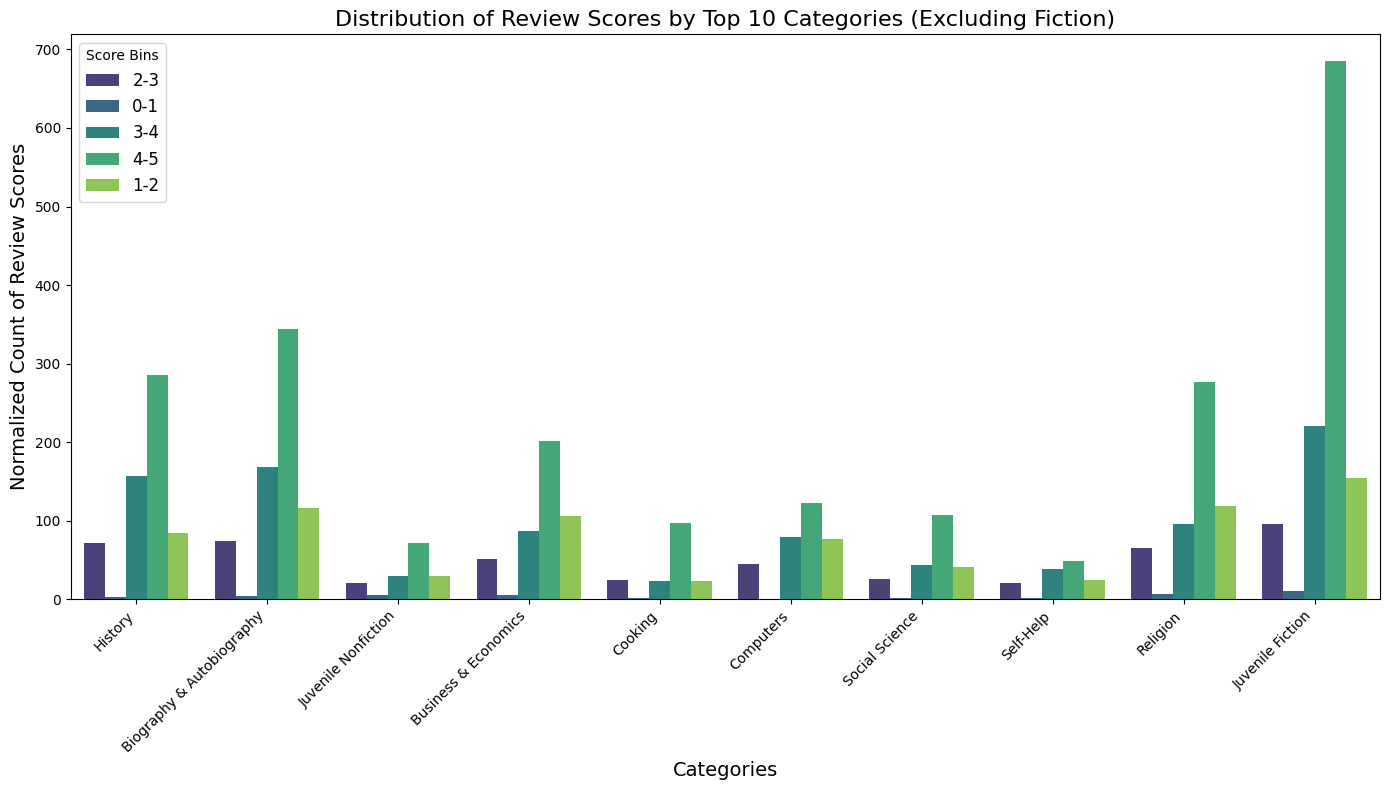

In [37]:
# Normalize the distribution within each category
window_spec = Window.partitionBy("categories")
# score_distribution_spark = score_distribution.withColumn(
#     "normalized_count", col("count")
# )

# Collect data for visualization
plot_data = score_distribution.collect()

# Prepare data for Seaborn
# Convert the collected data into a format Seaborn can work with
sns_data = {
    "categories": [],
    "score_bins": [],
    "count_per_bin": []
}

for row in plot_data:
    sns_data["categories"].append(row["categories"])
    sns_data["score_bins"].append(row["score_bins"])
    sns_data["count_per_bin"].append(row["count_per_bin"])

# Visualization with Seaborn
plt.figure(figsize=(14, 8))
sns.barplot(
    x=sns_data["categories"],
    y=sns_data["count_per_bin"],
    hue=sns_data["score_bins"],
    palette="viridis"
)

# Customize the plot
plt.title("Distribution of Review Scores by Top 10 Categories (Excluding Fiction)", fontsize=16)
plt.xlabel("Categories", fontsize=14)
plt.ylabel("Normalized Count of Review Scores", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Score Bins", fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()